In [1]:
import os, sys
import pandas as pd
import numpy as np
import random

from utils.method import read_bic_table, make_consensus_biclusters,zscore, write_bic_table
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
in_dir = "results_on_real_data_tuned_v2/TCGA_optimized/"
out_dir = "results_on_real_data_tuned_v2/TCGA_optimized/"
dataset = 'TCGA-BRCA'
exprs_file = "data/preprocessed_v6/TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.log2_exprs_z_v6.tsv"

suffix  = ".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv" 

In [3]:
exprs= pd.read_csv(exprs_file,sep = "\t",index_col=0)

In [4]:
n_runs = 5
cseed = 42 # seed for consensus of 5 runs
seeds = []
random.seed(cseed)
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
print("generate ",n_runs," seeds",seeds)

generate  5  seeds [670487, 116739, 26225, 777572, 288389]


In [5]:
# reading biclusters detected in independent runs
biclustering_results = []
for seed in seeds:
    biclusters = read_bic_table(in_dir+dataset+".seed="+str(seed)+suffix)
    print("seed %s n biclusters: %s"%(seed,biclusters.shape[0]))
    # reindexing
    biclusters.index = ["seed="+str(seed)+"_"+str(x) for x in biclusters.index.values ]
    biclustering_results.append(biclusters)


seed 670487 n biclusters: 168
seed 116739 n biclusters: 197
seed 26225 n biclusters: 150
seed 777572 n biclusters: 134
seed 288389 n biclusters: 210


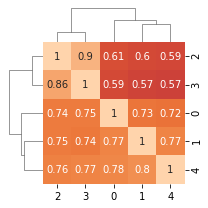

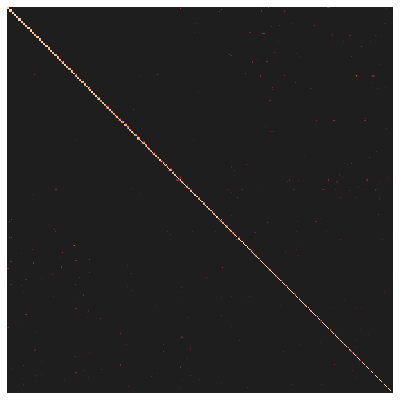

90 s for similarity matrix
	Running Louvain ...
		modularity: potts
	curve type: increasing


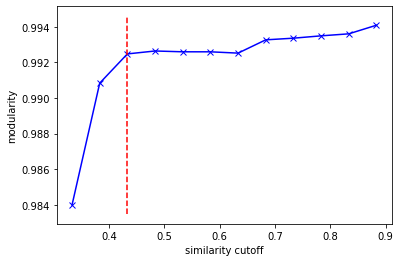

	Louvain runtime: modules detected in 1.44 s.
	modules: 210, not clustered features 86 
		similarity cutoff: 0.43 modularity: 0.992
all consensus biclusters: 296
detected 2+ times:208
43 s for making consensus biclusters from consensus gene sets


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
0,2.931461,2,38,"{CTAG1B, CTAG1A}","{TCGA-EW-A1PH-01, TCGA-AO-A0JL-01, TCGA-E2-A1L...","{CTAG1B, CTAG1A}",{},"{3385, 3386}","{1038, 529, 917, 279, 1047, 797, 289, 291, 48,...",UP,3,"{seed=26225_9, seed=777572_9, seed=288389_25}"
1,2.872521,2,6,"{C10orf120, DMBT1L1}","{TCGA-E2-A1IL-01, TCGA-S3-AA14-01, TCGA-A7-A0D...","{C10orf120, DMBT1L1}",{},"{1600, 3911}","{130, 132, 1066, 845, 975, 915}",UP,3,"{seed=288389_19, seed=116739_37, seed=670487_38}"
2,2.857572,331,195,"{HTR6, NR2E1, C4orf54, ZFP57, IYD, MDGA2, EN1,...","{TCGA-AN-A0G0-01, TCGA-B6-A0RT-01, TCGA-E9-A22...","{SLC26A9, SLC39A12, UGT8, HTR6, DMRTA1, FAM169...","{SLC44A4, TTC6, REEP6, HCAR1, EDARADD, PRR15, ...","{12288, 16397, 14358, 16411, 30, 51, 4148, 824...","{1024, 514, 1018, 1030, 519, 8, 1035, 524, 103...",BOTH,10,"{seed=26225_14, seed=288389_1, seed=26225_1, s..."
3,2.562175,115,13,"{BPIFA3, OR5B21, OR51B6, DLGAP2-AS1, LINC02011...","{TCGA-A7-A26I-01, TCGA-A7-A13E-01, TCGA-A7-A13...","{BPIFA3, OR5B21, OR51B6, DLGAP2-AS1, LINC02011...",{},"{8194, 10251, 13836, 13838, 2063, 15375, 13841...","{130, 131, 132, 133, 262, 135, 137, 138, 268, ...",UP,6,"{seed=777572_0, seed=670487_0, seed=288389_0, ..."
4,2.508195,36,44,"{CRNN, CLDN17, NPPB, BPIFA1, SCGB3A2, CYP2C18,...","{TCGA-BH-A0DL-01, TCGA-A7-A26I-01, TCGA-BH-A0H...","{CRNN, CLDN17, NPPB, SCGB3A2, BPIFA1, CYP2C18,...",{},"{5888, 5250, 3971, 9, 7567, 13078, 2849, 14114...","{128, 1024, 515, 132, 518, 519, 264, 138, 523,...",UP,8,"{seed=26225_20, seed=26225_12, seed=777572_5, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
203,1.202805,2,308,"{LHB, CGB5}","{TCGA-E9-A5UP-01, TCGA-A7-A5ZX-01, TCGA-LL-A44...","{LHB, CGB5}",{},"{7787, 2676}","{1, 22, 23, 30, 34, 37, 38, 39, 40, 44, 45, 46...",UP,2,"{seed=288389_203, seed=670487_159}"
204,1.178933,3,509,"{CLDN15, GP9, EGFL7}","{TCGA-C8-A8HR-01, TCGA-AQ-A7U7-01, TCGA-AC-A8O...","{CLDN15, GP9, EGFL7}",{},"{5823, 4314, 2847}","{0, 1, 2, 3, 5, 6, 7, 9, 11, 15, 22, 26, 28, 3...",UP,3,"{seed=116739_191, seed=670487_139, seed=288389..."
205,1.141976,2,212,"{NPHS1, PRODH2}","{TCGA-A2-A3XY-01, TCGA-AQ-A7U7-01, TCGA-3C-AAL...","{NPHS1, PRODH2}",{},"{11514, 9782}","{0, 2, 1028, 517, 1031, 1033, 522, 523, 12, 52...",UP,2,"{seed=116739_190, seed=288389_195}"
206,1.089286,2,203,"{PPP1R1C, NEUROD1}","{TCGA-A8-A0AD-01, TCGA-AN-A0G0-01, TCGA-E2-A1L...","{PPP1R1C, NEUROD1}",{},"{11340, 9550}","{1024, 1, 2, 9, 522, 526, 1039, 16, 1040, 531,...",UP,2,"{seed=116739_187, seed=288389_200}"


In [7]:
consensus_biclusters = make_consensus_biclusters(biclustering_results, zscore(exprs), 
                                                      seed = cseed,
                                                      verbose = True,
                                                      plot = True)

In [8]:
outfname = out_dir+"/"+dataset+".consensus_seed="+str(cseed)+suffix
print(outfname)
#write_bic_table(consensus_biclusters, outfname)

results_on_real_data_tuned_v2/TCGA_optimized//TCGA-BRCA.consensus_seed=42.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv


# Evaluating performance

In [9]:
from utils.eval import make_ref_groups
from utils.eval import calculate_perfromance, compare_gene_clusters

In [10]:
# TCGA
exprs_file_t = "data/preprocessed_v6/TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.log2_exprs_z_v6.tsv"
exprs_t= pd.read_csv(exprs_file_t,sep = "\t",index_col=0)

t_subtypes = pd.read_csv("data/preprocessed_v6/TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.subtypes_and_signatures_v6.tsv",sep = "\t",index_col=0)
t_annotation = pd.read_csv("data/preprocessed_v6/TCGA-BRCA_1079.Xena_TCGA_PanCan.annotation_v6.tsv",sep = "\t",index_col=0)

known_groups_t, all_samples_t = make_ref_groups(t_subtypes, t_annotation,exprs_t)


In [11]:
performances, best_matches = calculate_perfromance(consensus_biclusters, known_groups_t,all_samples_t,
                                                  performance_measure="ARI")
performances

PAM50          0.723389
Intrinsic      0.699051
PAM50_AB       0.472755
SCMOD2         0.485605
IHC            0.505737
Luminal        0.717999
Basal          0.938534
Her2           0.559805
LumA           0.465327
LumB           0.206061
Normal         0.089773
Claudin-low    0.115465
IHC_HER2       0.453328
IHC_ER         0.586139
IHC_PR         0.424782
IHC_TNBC       0.505250
NET_kmeans     0.770237
NET_ward       0.715634
dtype: float64

In [12]:
best_matches

,bm_id,ARI,weight,adj_pval,is_enriched,samples,n_samples,classification
Normal,21,0.089773,0.029657,0.000162,True,"{TCGA-AN-A0G0-01, TCGA-B6-A0RT-01, TCGA-E9-A22...",193,PAM50
Her2,22,0.559805,0.100093,0.000148,True,"{TCGA-C8-A12Q-01, TCGA-A8-A07B-01, TCGA-UU-A93...",118,PAM50
Basal,2,0.938534,0.180723,0.000335,True,"{TCGA-AN-A0G0-01, TCGA-B6-A0RT-01, TCGA-E9-A22...",195,PAM50
Luminal,11,0.717999,0.689527,0.0006,False,"{TCGA-AN-A0G0-01, TCGA-B6-A0RT-01, TCGA-A8-A07...",266,PAM50
Normal,21,0.089773,0.02847,0.000162,True,"{TCGA-AN-A0G0-01, TCGA-B6-A0RT-01, TCGA-E9-A22...",193,Intrinsic
Her2,22,0.559805,0.096085,0.000148,True,"{TCGA-C8-A12Q-01, TCGA-A8-A07B-01, TCGA-UU-A93...",118,Intrinsic
Basal,2,0.938534,0.173488,0.000335,True,"{TCGA-AN-A0G0-01, TCGA-B6-A0RT-01, TCGA-E9-A22...",195,Intrinsic
Luminal,11,0.717999,0.661922,0.0006,False,"{TCGA-AN-A0G0-01, TCGA-B6-A0RT-01, TCGA-A8-A07...",266,Intrinsic
Claudin-low,10,0.115465,0.040036,0.001455,True,"{TCGA-B6-A0RT-01, TCGA-E9-A22G-01, TCGA-A2-A3X...",133,Intrinsic
LumA,155,0.465327,0.39481,0.000758,True,"{TCGA-AQ-A7U7-01, TCGA-EW-A1IX-01, TCGA-AC-A8O...",443,PAM50_AB


# METABRIC

In [14]:
in_dir = "results_on_real_data_tuned_v2/METABRIC_optimized/"
out_dir = "results_on_real_data_tuned_v2/METABRIC_optimized/"
dataset = 'METABRIC'
exprs_file = "data/preprocessed_v6/METABRIC_1904_17Kgenes.log2_exprs_z_v6.tsv"

suffix  = ".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv" 

In [15]:
exprs= pd.read_csv(exprs_file,sep = "\t",index_col=0)

n_runs = 5
cseed = 42 # seed for consensus of 5 runs
seeds = []
random.seed(cseed)
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
print("generate ",n_runs," seeds",seeds)

# reading biclusters detected in independent runs
biclustering_results = []
for seed in seeds:
    biclusters = read_bic_table(in_dir+dataset+".seed="+str(seed)+suffix)
    print("seed %s n biclusters: %s"%(seed,biclusters.shape[0]))
    # reindexing
    biclusters.index = ["seed="+str(seed)+"_"+str(x) for x in biclusters.index.values ]
    biclustering_results.append(biclusters)



generate  5  seeds [670487, 116739, 26225, 777572, 288389]
seed 670487 n biclusters: 168
seed 116739 n biclusters: 164
seed 26225 n biclusters: 159
seed 777572 n biclusters: 161
seed 288389 n biclusters: 154


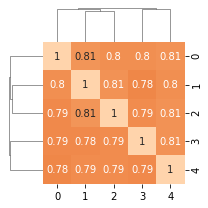

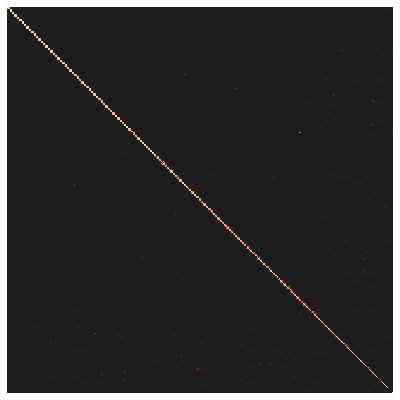

72 s for similarity matrix
	Running Louvain ...
		modularity: potts
	curve type: increasing


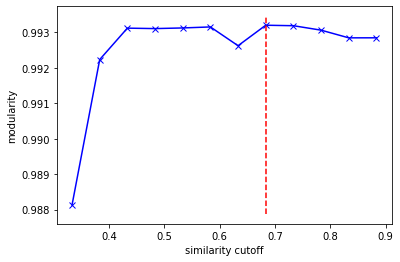

	Louvain runtime: modules detected in 0.76 s.
	modules: 180, not clustered features 72 
		similarity cutoff: 0.68 modularity: 0.993
all consensus biclusters: 252
detected 2+ times:180
58 s for making consensus biclusters from consensus gene sets


In [16]:
consensus_biclusters = make_consensus_biclusters(biclustering_results, zscore(exprs), 
                                                      seed = cseed,
                                                      verbose = True,
                                                      plot = True)


In [17]:
exprs_file_m = "data/preprocessed_v6/METABRIC_1904_17Kgenes.log2_exprs_z_v6.tsv"
exprs_m= pd.read_csv(exprs_file_m,sep = "\t",index_col=0)

m_subtypes = pd.read_csv("data/preprocessed_v6/METABRIC_1904_17Kgenes.subtypes_and_signatures_v6.tsv",sep = "\t",index_col=0)
m_annotation = pd.read_csv("data/preprocessed_v6/METABRIC_1904.annotation_v6.tsv",sep = "\t",index_col=0)

known_groups_m, all_samples_m = make_ref_groups(m_subtypes, m_annotation,exprs_m)

In [18]:
performances, best_matches = calculate_perfromance(consensus_biclusters, known_groups_m,all_samples_m,
                                                  performance_measure="ARI")
performances

PAM50          0.754447
Intrinsic      0.729983
PAM50_AB       0.334729
SCMOD2         0.399722
IHC            0.624434
Luminal        0.792972
Basal          0.891643
Her2           0.534394
LumA           0.239427
LumB           0.180247
Normal         0.157154
Claudin-low    0.188365
IHC_HER2       0.877487
IHC_ER         0.810650
IHC_PR         0.269513
IHC_TNBC       0.713750
NET_kmeans     0.891851
NET_ward       0.747780
dtype: float64

In [19]:
best_matches

,bm_id,ARI,weight,adj_pval,is_enriched,samples,n_samples,classification
Normal,73,0.157154,0.028361,0.000078,True,"{MB-3058, MB-0538, MB-0869, MB-5420, MB-4743, ...",303,PAM50
Her2,14,0.534394,0.128151,0.00031,True,"{MB-0482, MB-7296, MB-5420, MB-2758, MB-4289, ...",245,PAM50
Basal,0,0.891643,0.128151,0.000464,True,"{MB-3058, MB-0869, MB-5100, MB-5162, MB-4758, ...",255,PAM50
Luminal,7,0.792972,0.715336,0.000673,False,"{MB-3028, MB-5100, MB-4763, MB-7270, MB-0346, ...",520,PAM50
Normal,73,0.157154,0.027136,0.000078,True,"{MB-3058, MB-0538, MB-0869, MB-5420, MB-4743, ...",303,Intrinsic
Her2,14,0.534394,0.122613,0.00031,True,"{MB-0482, MB-7296, MB-5420, MB-2758, MB-4289, ...",245,Intrinsic
Basal,0,0.891643,0.122613,0.000464,True,"{MB-3058, MB-0869, MB-5100, MB-5162, MB-4758, ...",255,Intrinsic
Luminal,7,0.792972,0.684422,0.000673,False,"{MB-3028, MB-5100, MB-4763, MB-7270, MB-0346, ...",520,Intrinsic
Claudin-low,0,0.188365,0.043216,0.00011,True,"{MB-3058, MB-0869, MB-5100, MB-5162, MB-4758, ...",255,Intrinsic
LumA,57,0.239427,0.314076,0.000555,True,"{MB-0607, MB-5100, MB-4529, MB-0068, MB-5092, ...",466,PAM50_AB
